## Serialization user guide

Sometimes it is needed to train a model on the one computer and use on the other. `bosk` provides a serialization mechanism for the pipelines and blocks instances.


### A note about serialization requirements

The pipeline is serializable if all the blocks can be serialized. If all values of your block's `__dict__` are serializable, you don't have to redefine `__setstate__` and `__getstate__` methods. The common information about serialization and those methods can be found [here](https://docs.python.org/3/library/pickle.html#what-can-be-pickled-and-unpickled). `auto_block` wrapper can automatically make `__setstate__` and `__getstate__` if you pass the corresponding argument. The important thing is that if the block defines slots metainformation dynamically, you should use `ZipPipelineSerializer` to overcome deserealization difficulties.

In [1]:
from bosk.executor.topological import TopologicalExecutor
from bosk.painter.graphviz import GraphvizPainter
from bosk.pipeline.builder.functional import FunctionalPipelineBuilder
from bosk.pipeline.serializer.joblib import JoblibPipelineSerializer
from bosk.pipeline.serializer.zip import ZipPipelineSerializer
from bosk.pipeline.serializer.skops import SkopsBlockSerializer
from bosk.stages import Stage
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import numpy as np
from IPython.display import Image

Consider we have following pipeline:

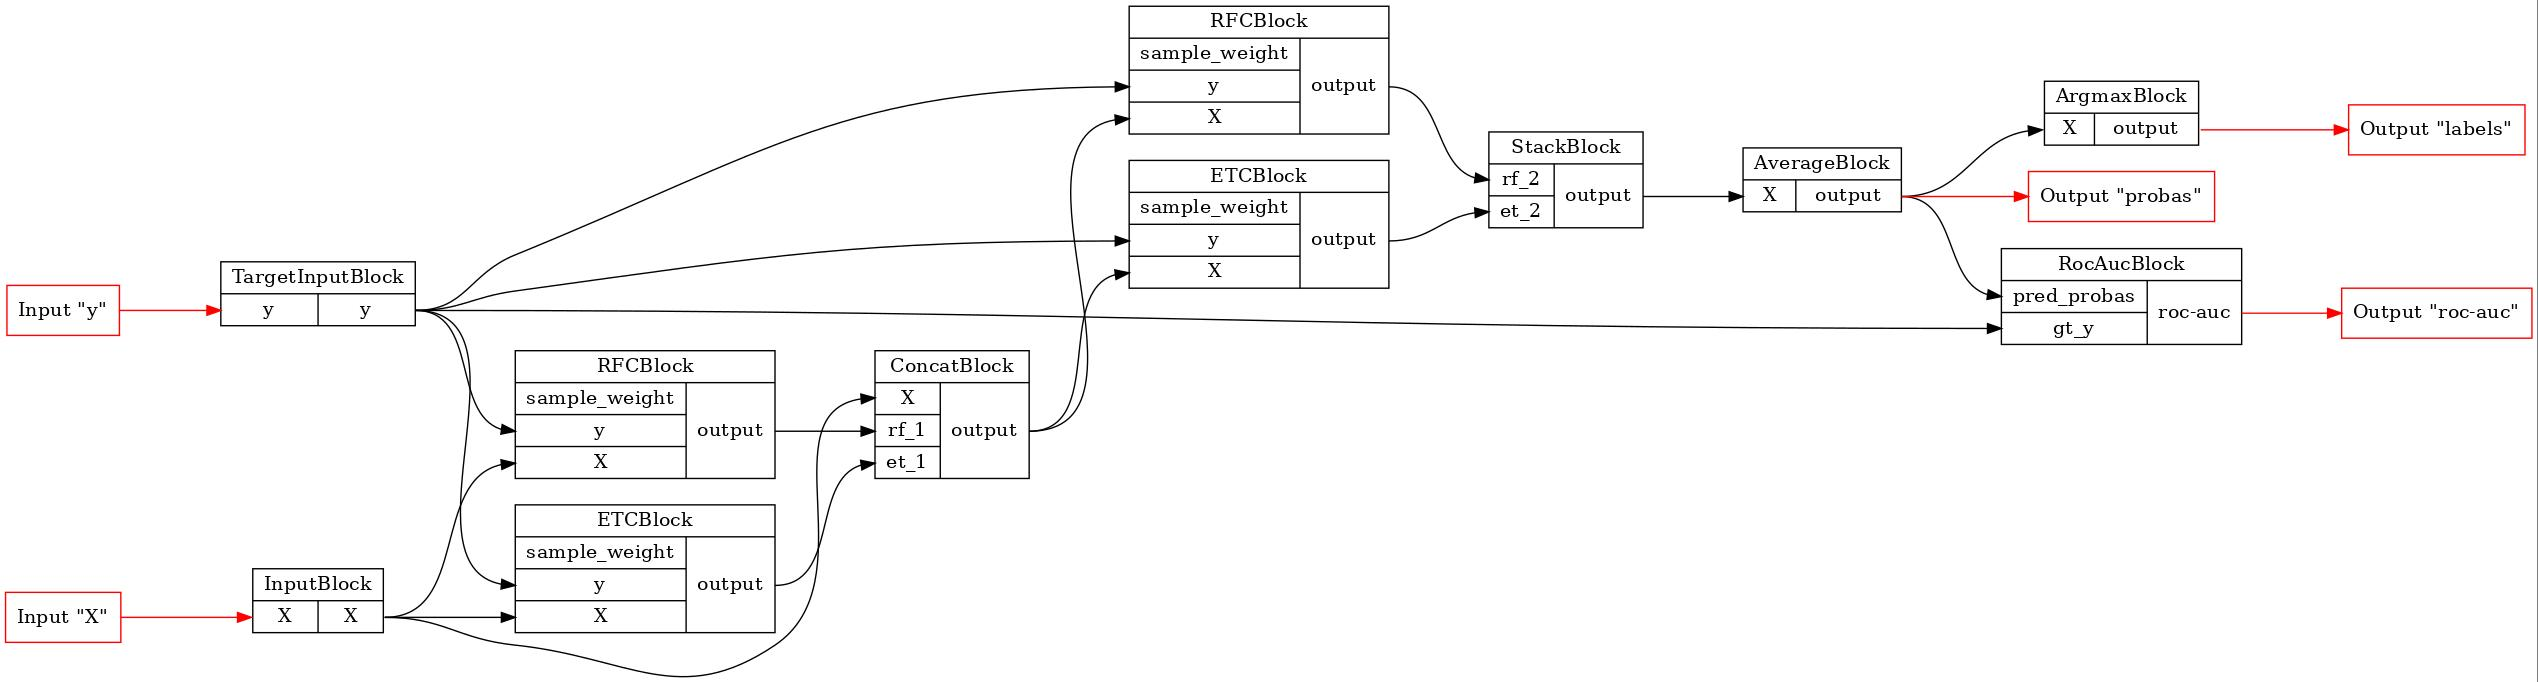

In [2]:
n_estimators = 17
b = FunctionalPipelineBuilder()
X, y = b.Input()(), b.TargetInput()()
rf_1 = b.RFC(n_estimators=n_estimators)(X=X, y=y)
et_1 = b.ETC(n_estimators=n_estimators)(X=X, y=y)
concat_1 = b.Concat(['X', 'rf_1', 'et_1'])(X=X, rf_1=rf_1, et_1=et_1)
rf_2 = b.RFC(n_estimators=n_estimators)(X=concat_1, y=y)
et_2 = b.ETC(n_estimators=n_estimators)(X=concat_1, y=y)
stack = b.Stack(['rf_2', 'et_2'], axis=1)(rf_2=rf_2, et_2=et_2)
average = b.Average(axis=1)(X=stack)
argmax = b.Argmax(axis=1)(X=average)
roc_auc = b.RocAuc()(gt_y=y, pred_probas=average)
pipeline = b.build(
    {'X': X, 'y': y},
    {'labels': argmax, 'probas': average, 'roc-auc': roc_auc}
)
GraphvizPainter(figure_dpi=100).from_pipeline(pipeline).render('pipeline.jpeg')
display(Image('pipeline.jpeg'))

Let's serialize the newly created model and compare the result of the deserialization with the original. We will use `skops` for the blocks serialization and save the pipeline to a zip file.

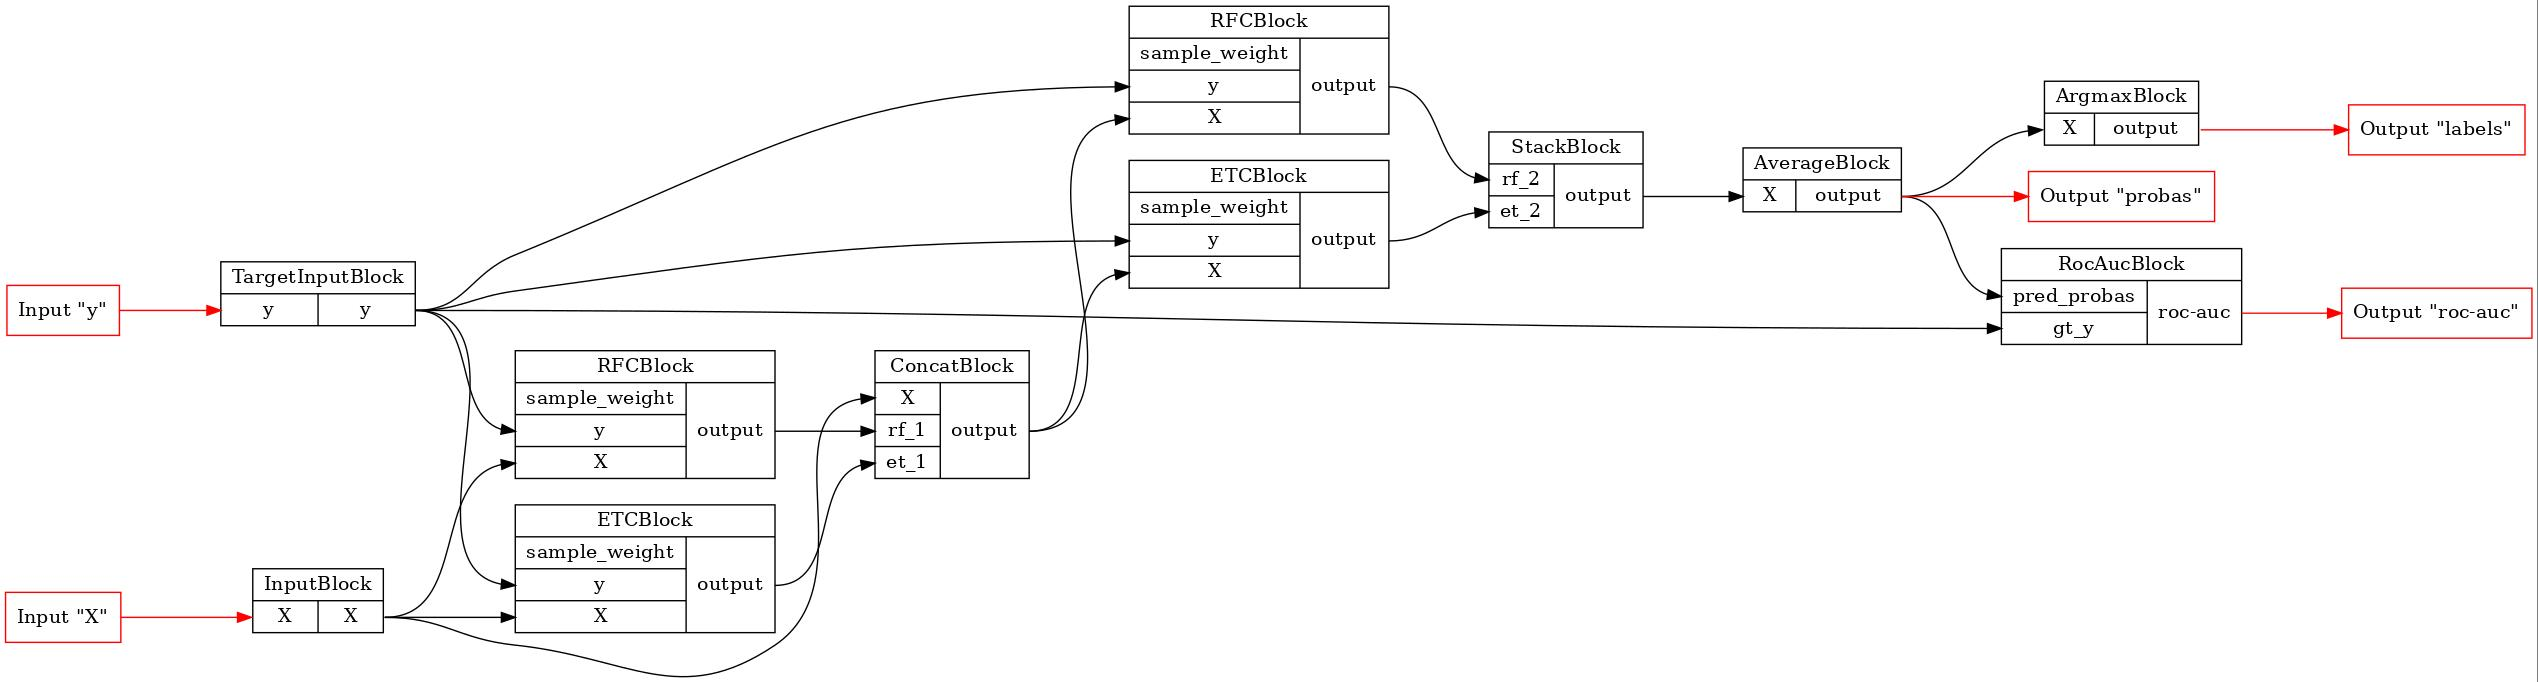

In [3]:
zip_serial = ZipPipelineSerializer(SkopsBlockSerializer())
zip_serial.dump(pipeline, 'pipeline.zip')
pipeline = zip_serial.load('pipeline.zip')
GraphvizPainter(figure_dpi=100).from_pipeline(pipeline).render('pipeline.jpeg')
display(Image('pipeline.jpeg'))

As we can see, the pipeline structure remains still.

Let's train our model and try to do the serialization test with the fitted instance. We will use `joblib` this time.

In [4]:
all_X, all_y = make_moons(100, noise=0.5)
train_X, test_X, train_y, _ = train_test_split(all_X, all_y, test_size=0.2)
train_data = {'X': train_X, 'y': train_y}
test_data = {'X': test_X}
fit_executor = TopologicalExecutor(
    pipeline,
    stage=Stage.FIT,
    inputs=['X', 'y'],
    outputs=['probas'],
)
fit_results = fit_executor(train_data)
joblib_serial = JoblibPipelineSerializer()
joblib_serial.dump(pipeline, 'pipeline.gz')
pipeline_copy = joblib_serial.load('pipeline.gz')
exec_1 = TopologicalExecutor(pipeline, Stage.TRANSFORM, inputs=['X'], outputs=['probas'])
exec_2 = TopologicalExecutor(pipeline_copy, Stage.TRANSFORM, inputs=['X'], outputs=['probas'])
res_1 = exec_1(test_data).numpy()
res_2 = exec_2(test_data).numpy()
print("L1 metric between the original and deserialized pipelines' probabilities:",
      np.sum(np.abs(res_1['probas'] - res_2['probas'])))

L1 metric between the original and deserialized pipelines' probabilities: 0.0
